In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import seaborn as sns
from scipy.stats import skew 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install tikzplotlib

     |████████████████████████████████| 53 kB 2.0 MB/s 


In [ ]:
import tikzplotlib


* Station Code: Código único para cada lugar
* Locations: Nome do rio e para onde flui
* State: O estado em que o rio está fluindo
* Temp: Valor médio de temperatura
* DO: Valor médio de oxigênio dissolvido
* PH: Valor médio de pH
* Conductivity: Valor médio de condutividade
* BOD: Valor médio da demanda bioquímica de oxigênio
* NITRATE_N_NITRITE_N: Valor médio de nitrato-n e nitrito-n
* FECAL_COLIFORM: Valor médio de coliformes fecais
* TOTAL_COLIFORM: Valor médio de coliformes totais





In [ ]:
path ="/content/waterquality.csv"
dados = pd.read_csv(path,sep=',', engine='python')
dados.head()

,STATION CODE,LOCATIONS,STATE,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,29.2,6.4,8.1,735.0,3.4,2.00,3.0,73.0
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,24.5,6.0,8.0,270.0,3.1,2.00,72.0,182.0
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,25.8,5.5,7.8,355.0,4.2,9.00,59.0,133.0
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,24.8,5.5,7.8,371.0,5.6,3.55,90.0,283.0
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,25.7,5.7,7.9,294.0,3.2,2.69,45.0,132.0


**Pré-processamento**

 Verifica-se a presença ou não de dados faltantes. Realiza também uma normalização dos dados em relação a média e o desvio padrão em virtude da ordem de grandeza dos dados.


In [ ]:
dados =dados.drop(['STATION CODE', 'LOCATIONS','STATE'], axis=1)

In [ ]:
dados.isnull().sum()

TEMP                    5
DO                      2
pH                      0
CONDUCTIVITY           30
BOD                     6
NITRATE_N_NITRITE_N     2
FECAL_COLIFORM         82
TOTAL_COLIFORM         39
dtype: int64

Verifica-se  a presença de dados faltantes, opta-se por preencher com a o último registro válido 

In [ ]:
dadostratados = dados.fillna(method='bfill')
dadostratados.isnull().sum()

TEMP                   0
DO                     0
pH                     0
CONDUCTIVITY           0
BOD                    0
NITRATE_N_NITRITE_N    0
FECAL_COLIFORM         0
TOTAL_COLIFORM         0
dtype: int64

In [ ]:
variaveis = ['TEMP','DO','pH','CONDUCTIVITY','BOD','NITRATE_N_NITRITE_N','FECAL_COLIFORM','TOTAL_COLIFORM']

In [ ]:
dadostratados.head()

,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
0,29.2,6.4,8.1,735.0,3.4,2.00,3.0,73.0
1,24.5,6.0,8.0,270.0,3.1,2.00,72.0,182.0
2,25.8,5.5,7.8,355.0,4.2,9.00,59.0,133.0
3,24.8,5.5,7.8,371.0,5.6,3.55,90.0,283.0
4,25.7,5.7,7.9,294.0,3.2,2.69,45.0,132.0


Seja $X_i$ um preditor do dataset, $\mu_i$ e $\sigma_i$ a média e o desvio padrão desse respectivo preditor, realiza-se a seguinte normalização:
$$
X^{*}_i=\frac{X_i-\mu_i}{\sigma_i}
$$

In [ ]:
dadostratados = (dadostratados - dadostratados.mean())/dadostratados.std()

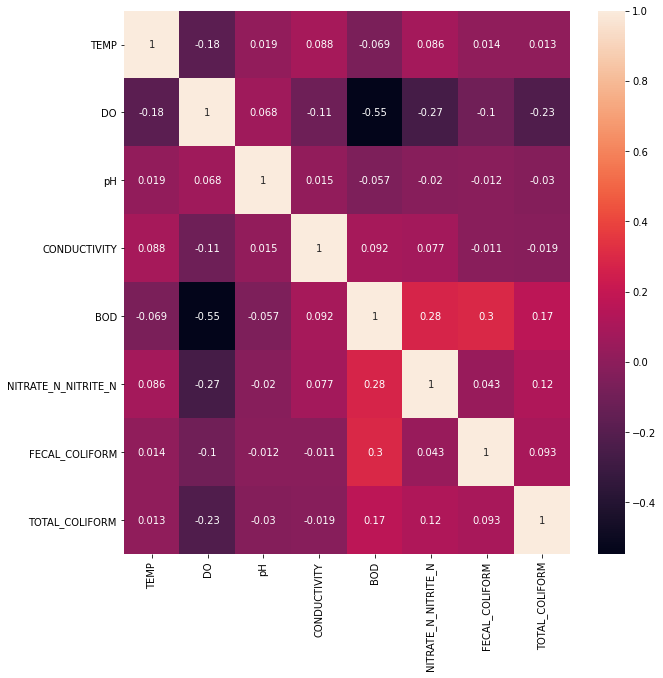

In [ ]:
plt.figure(figsize=(10, 10))
corr = dadostratados.corr()
_ = sns.heatmap(corr, annot=True )

Verifica-se a baixa correlação entre  a BOD e os seguintes preditores: temperatura, pH e condutividade.Então em virtude da sua pouca colacaboração para a construção do modelo opta-se por não considerá-los.

In [ ]:
variaveis = ['DO','BOD','NITRATE_N_NITRITE_N','FECAL_COLIFORM','TOTAL_COLIFORM']
dadostratados =dadostratados.drop(['pH', 'TEMP','CONDUCTIVITY'], axis=1)

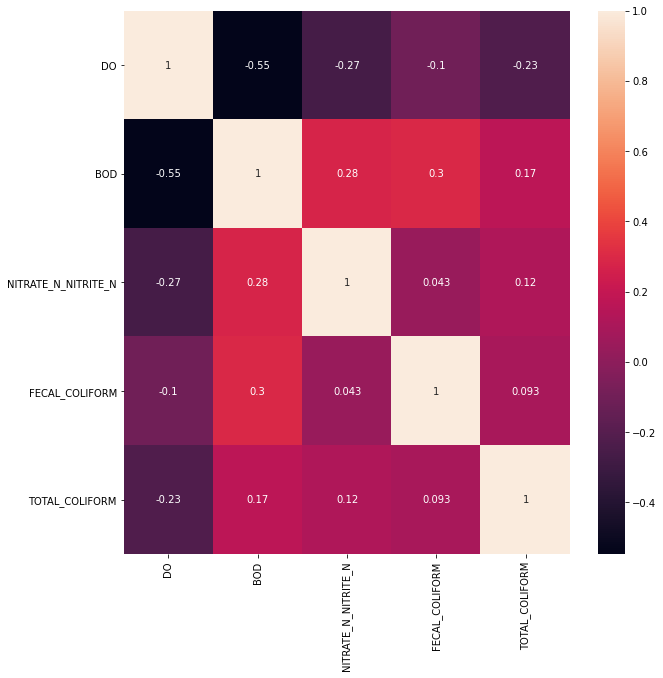

In [ ]:
plt.figure(figsize=(10, 10))
corr = dadostratados.corr()
_ = sns.heatmap(corr, annot=True )

In [ ]:
dadostratados

,DO,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
0,0.012500,-0.224315,0.216260,-0.230614,-0.082107
1,-0.232009,-0.259761,0.216260,-0.228193,-0.082030
2,-0.537646,-0.129792,2.699759,-0.228649,-0.082065
3,-0.537646,0.035623,0.766177,-0.227561,-0.081958
4,-0.415392,-0.247945,0.461062,-0.229140,-0.082065
...,...,...,...,...,...
529,-1.210048,-0.484252,-0.138526,-0.230544,-0.082149
530,-0.476519,-0.496068,0.571045,-0.230579,-0.082154
531,-0.354264,-0.484252,0.571045,-0.230579,-0.082155
532,-1.393430,-0.354283,0.216260,-0.230474,-0.082112


 ## Métricas de avaliação e validação

  Uma métrica qualitativa de  avaliação do desempenho é o erro quadrático médio (MSE) é dado pela soma dos erros ao quadrado  dividido pelo total de amostras
  
 \begin{equation}
 MSE = \frac{1}{N}\sum_{i=1}^{N}\left ( y_i-\hat{y}_i \right )^2
 \end{equation}
 
  Tirando a raíz quadrada do  $MSE$ defini-se o $RMSE$ :
 
 
  \begin{equation}
 RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}\left ( y_i-\hat{y}_i \right )^2}
 \end{equation}
 
  O $RMSE$ mede a performace do modelo, o $R^2$ representa a proporção da variância para uma variável dependente que é explicada por uma variável independente em um modelo de regressão, o qual é difinido pela da seguinte forma:
   \begin{equation}
 R^2 =1 -\frac{RSS}{TSS}
 \end{equation}
 onde $RSS=  \sum_{i=1}^{N}(y_i-\hat{y}_i)^2$, que pode ser interpretado como  uma medida dispersão dos dados gerados pelo em relação aos originais e $TSS = \sum_{i=1}^{N}\left ( y_i -\bar{y}\right )$, que mede a variância em relação a saída.  

## Regressão linear por mínimos quadrados
A regressão linear é uma abordagem muito simples para o aprendizado supervisionado. É uma abordagem muito simples para prever uma resposta quantitativa  de uma saída $Y$ no
tendo como  base em uma única variável preditora  de entrada $X$. é preciso que exista uma relação  aproximadamente linear entre $X$ e $Y$:
\begin{equation}
Y \approx \beta_0+\beta_1X_1+\beta_1X_1+...+\beta_NX_N
\end{equation}

Onde $\beta_0$,$\beta_1$,...,$\beta_N$ são  constantes desconhecidas a seren determinadas no processo, . Os dados são utilizados para estimar os coeficientes. $\hat{\beta}_0$ , $\hat{\beta}_1$,...,$\hat{\beta}_1$, que serão utilizados para determinar o nosso  estimados $\hat{y}$. Nesse processo existe a presença de um erro irredutível, o objetivo consiste em minimizar a soma dos erros quadrados:
\begin{equation}
J\left ( \beta_0,\beta_1,..,\beta_N \right ) =   \sum_{i=1}^{N}e_i^2 = \sum_{i=1}^{N}\left ( y_i-\hat{\beta}_0-\hat{\beta}_1x_i \right )^2
\end{equation}

Igualando a derivada a função custo a zero, determina-se as coeficientes do modelo,
\begin{equation}
 \frac{\partial J}{\partial \beta_n}   =0
\end{equation}


Obtem-se  um sistema de equações com $N$  incógnitas. 



In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
X = dadostratados.drop(['BOD'], axis=1)
Y = dadostratados['BOD']
X_train, X_test, y_train, y_test = train_test_split(  X, Y, test_size=0.30, random_state=42) 
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(regr, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 0.8810679504653917)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
RMSE = cross_val_score(regr, X_test, y_test,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE teste',RMSE

('RMSE teste', 4.612660953204307)

In [ ]:
r2_score(y_train, regr.predict(X_train))

0.4088593584234066

In [ ]:
r2_score(y_test, regr.predict(X_test))

0.23414777556028

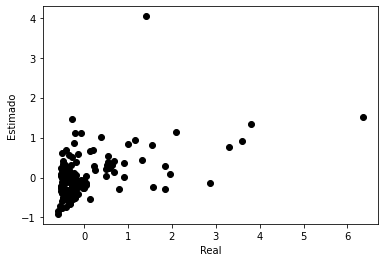

In [ ]:
y_pred = np.array(regr.predict(X_test))
plt.scatter(y_test,y_pred,color='black')
plt.xlabel('Real')
plt.ylabel('Estimado')
 
tikzplotlib.save("real_estimado_regrlinear.pgf")

## Modelos penalizados- Ridge Regression 
Os coeficientes produzidos pela regressão de mínimos quadrados ordinários são imparciais e, este modelo também tem a variância mais baixa. Dado que o $MSE$ consiste em uma combinação de variância e bias, é possível gerar  modelos com MSEs menores, faz com que estimativas dos parâmetros obitidos sejam tendenciosas. O normal que ocorra um pequeno aumento no viés inplique em uma queda considerável na variância, produzindo um $MSE$ menor do que os coeficientes de regressão de mínimos quadrados. Uma consequência das grandes correlações entre as variâncias do preditor é que a variância pode se tornar muito grande.  
Uma possível solução seria penalizar a soma dos erros quadráticos. No presente estudo utilizou-se a Ridge regression, a qual  adiciona uma penalidade na soma do parâmetro de regressão quadrado:


\begin{equation}
RSS_{L2} = \sum_{i=1}^{N}\left ( y_i -\hat{y}_i\right )+\lambda\sum_{j=1}^{N}\beta^2_j
\end{equation}
Este método reduz as estimativas para 0 à medida que a penalidade $\lambda$ torna-se  grande.Ao penalizar o moelo, realiza-se uma compensação entre a variância e o viés do modelo.


In [ ]:
from sklearn.linear_model import Ridge
def ridge(x, y,alpha,preditor):
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
    rr = Ridge(alpha=alpha) 
    rr.fit(X_train, y_train)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    RMSE = cross_val_score(rr, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
    RMSE = np.sqrt(-RMSE.mean())
    return RMSE

In [ ]:
RMSEval = []
lambdas  = [ ]
l2 = []
alpha = np.linspace(0.01,300,10)
for j in range(0,1):
    for i in range(0,10):
        RMSEval.append(ridge(dadostratados.drop(['BOD'], axis=1), dadostratados['BOD'].values.reshape(-1, 1),alpha[i],variaveis[0]))
        lambdas.append(alpha[i])
    print(round(min(RMSEval),4), lambdas[RMSEval.index(min(RMSEval))])
    l2.append(lambdas[RMSEval.index(min(RMSEval))])
print('ideal lambda:',l2)

0.8567 100.00666666666667
ideal lambda: [100.00666666666667]


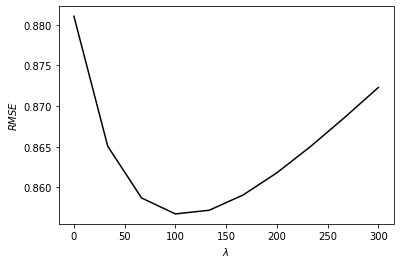

In [ ]:
plt.plot(alpha,RMSEval,color='black') 
plt.xlabel('$\lambda$')
plt.ylabel('$RMSE$')

tikzplotlib.save("rmsexlambda.pgf")

In [ ]:
x=dadostratados.drop(['BOD'], axis=1)
y= dadostratados['BOD'].values.reshape(-1, 1)
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
rr = Ridge(alpha=l2) 
rr.fit(X_train, y_train)


Ridge(alpha=[100.00666666666667], copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001)

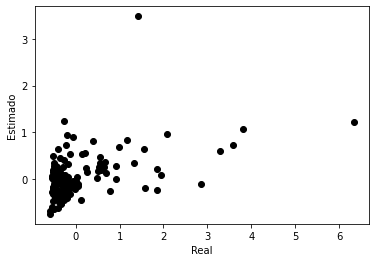

In [ ]:
y_pred = np.array(rr.predict(X_test))
plt.scatter(y_test,y_pred,color='black')
plt.xlabel('Real')
plt.ylabel('Estimado')
 
tikzplotlib.save("real_estimado_ridge.pgf")

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(rr, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 0.8567388498239565)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(rr, X_test, y_test,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 0.7996933290944075)

In [ ]:
r2_score(y_train, rr.predict(X_train))

0.3985003231324987

In [ ]:
r2_score(y_test, rr.predict(X_test))

0.23799158657055397

# Regressão por Minimos Quadrados Parciais - PLS

In [ ]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression, PLSSVD

X  = dadostratados.drop(['BOD'], axis=1).astype('float64')
y= dadostratados['BOD']
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)


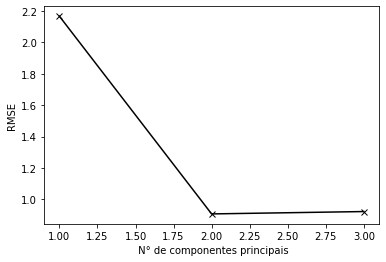

In [ ]:
from sklearn.preprocessing import scale 

n = len(X_train)
kf_10 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
rmse = []
for i in np.arange(1,4):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(-score))

plt.plot(np.arange(1, 4), np.array(rmse), '-x',color='black')
plt.xlabel(' N° de componentes principais')
plt.ylabel('RMSE')
tikzplotlib.save("pls.pgf")

In [ ]:
pls = PLSRegression(n_components=3)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(pls, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 0.8966774590440122)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(pls, X_test, y_test,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 17.548768710036747)

In [ ]:
pls.fit(X, Y)

y_pred = pls.predict(X)

In [ ]:
r2_score(y_train, pls.predict(X_train))

0.41097769073945556

In [ ]:
r2_score(y_test, pls.predict(X_test))

0.31959836677927844

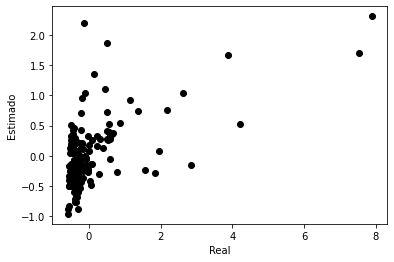

In [ ]:
y_pred =pls.predict(X_test)
plt.scatter(y_test,y_pred,color='black')
plt.xlabel('Real')
plt.ylabel('Estimado')
 
tikzplotlib.save("real_estimado_pls.pgf")

#Rede neural

In [ ]:
X = dadostratados.drop(['BOD'], axis=1)
Y = dadostratados['BOD']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(  X, Y, test_size=0.30, random_state=42) 


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=42, max_iter=5000).fit(X_train, y_train)


In [ ]:
mean_absolute_error(y_test, regr.predict(X_test))

0.34194475244123634

In [ ]:
r2_score(y_test, regr.predict(X_test))

0.571602132806933

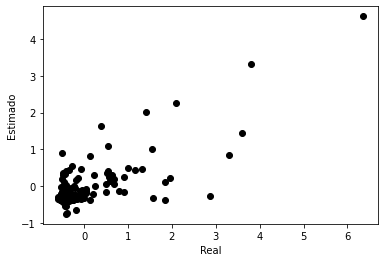

In [ ]:
y_pred =regr.predict(X_test)
plt.scatter(y_test,y_pred,color='black')
plt.xlabel('Real')
plt.ylabel('Estimado')
 
tikzplotlib.save("real_estimado_mlp.pgf")

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
RMSE = cross_val_score(regr, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
RMSE = np.sqrt(-RMSE.mean())
'RMSE treino',RMSE

('RMSE treino', 0.8479495179014089)